&emsp;이번 포스팅에서는 파이썬 **Dask DataFrame**을 활용한 간단한 예제를 다뤄보도록 하겠습니다.

# 목차

* [Dask DataFrame](#Dask-DataFrame)
* [Dask 클라이언트](#Dask-클라이언트)
* [난수 데이터프레임 생성](#난수-데이터프레임-생성)
* [Dask에서 Pandas 기능 사용하기](#Dask에서-Pandas-기능-사용하기)
* [메모리에 데이터 유지](#메모리에-데이터-유지)
* [시계열 작업](#시계열-작업)
* [인덱스 설정](#인덱스-설정)
* [그룹별 함수 적용하기](#그룹별-함수-적용하기)

---

# Dask DataFrame

<figure>
    <img src="https://examples.dask.org/_images/dask-dataframe.svg" width="300px">
</figure>

&emsp;Dask DataFrame은 위의 그림처럼 인덱스를 따라 분할된 여러 Pandas 데이터프레임으로 구성되어 있습니다. 따라서, Dask DataFrame은 Pandas API가 갖고있는 기능들을 지원합니다.

---

# Dask 클라이언트

&emsp;Dask 클라이언트(client)는 필요에 따라 실행해도 되고, 실행하지 않아도 됩니다. Dask 클라이언트는 연산 작업 현황에 대한 정보를 얻는데 유용한 대시보드(dashboard)를 제공합니다.

&emsp;아래 코드와 같이 클라이언트를 생성하면 대시보드에 대한 링크가 표시됩니다. 이 링크를 클릭해, 작업을 실행하는 동안 다른 화면 한쪽에 대시보드를 열어 두는 것이 좋습니다. 대시보드를 작업 화면과 동시에 보는 것은 분석 및 학습을 수행할 때 매우 유용합니다.

In [1]:
from dask.distributed import Client

client = Client(n_workers=4, threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 15.87 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50433,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 15.87 GiB
Comm: tcp://127.0.0.1:50458,Total threads: 1
Dashboard: http://127.0.0.1:50462/status,Memory: 3.97 GiB
Nanny: tcp://127.0.0.1:50436,


---

# 난수 데이터프레임 생성

&emsp;여기에서 사용할 데이터를 만들기 위해, 다음과 같은 특성을 가진 임의의 시계열 데이터를 생성합니다.  

1. 2000년 1월 한 달의 기간동안 매초마다의 레코드를 저장합니다.
2. 해당 월을 일 단위로 분할하여, 1일 치 레코드를 분할된 데이터프레임으로 만듭니다.
3. 데이터프레임의 인덱스는 datetime이며, 그 외에 name, id, x, y 열로 구성되어 있습니다.

&emsp;이 시계열 데이터는 약 240 MB 크기의 작은 데이터셋입니다. 더 큰 데이터셋으로 만들기 위해, [`dask.datasets.timeseries()`](https://docs.dask.org/en/stable/api.html#dask.datasets.timeseries) 인수를 설정하여 일 수(the number of days)를 늘리거나 데이터 포인트의 시간 간격을 줄일 수 있습니다. Dask DataFrame은 Pandas 데이터프레임과 다르게 연산이 필요할 때만 데이터 값들이 로드됩니다. 이러한 Dask의 특성을 *lazy*하다고 표현합니다. 따라서, 데이터 값이 노출되지 않고 줄임표(`...`)로 대체됩니다.

In [2]:
import dask

df = dask.datasets.timeseries(start="2023-01-01", end="2023-12-31")
df

,name,id,x,y
npartitions=364,,,,
2023-01-01,string,int32,float64,float64
2023-01-02,...,...,...,...
...,...,...,...,...
2023-12-30,...,...,...,...
2023-12-31,...,...,...,...


&emsp;그래도 열 이름과 데이터 타입(dtype)은 확인할 수 있습니다.

In [3]:
df.dtypes

name    string[pyarrow]
id                int32
x               float64
y               float64
dtype: object

&emsp;아래 `.head()`와 같이 일부 작업을 하는 경우에는, 데이터 값이 자동으로 노출 됩니다.

In [4]:
df.head()

,name,id,x,y
timestamp,,,,
2023-01-01 00:00:00,Patricia,1037,0.680683,0.417529
2023-01-01 00:00:01,Victor,946,0.156466,-0.976515
2023-01-01 00:00:02,Zelda,976,0.923796,0.379397
2023-01-01 00:00:03,Zelda,971,-0.063157,-0.555303
2023-01-01 00:00:04,Jerry,970,-0.634929,0.444818


---

# Dask에서 Pandas 기능 사용하기

&emsp;Dask 데이터프레임은 대부분의 Pandas 데이터프레임과 동일한 방식으로 작업할 수 있습니다. 아래 예제는 Dask 데이터프레임에서 어떠한 조건을 기준으로 데이터를 분할한 다음, `x` 열에 있는 데이터의 표준 편차를 계산하는 방법을 보여줍니다.

In [5]:
df2 = df[df.y > 0]
df3 = df2.groupby("name").x.std()
df3

Dask Series Structure:
npartitions=1
    float64
        ...
Name: x, dtype: float64
Dask Name: sqrt, 10 graph layers

&emsp;`df3`의 데이터는 아직까지 실제로 연산되지는 않으므로 줄임표(`...`)로 표시됩니다. 연산 결과를 Pandas 데이터프레임 또는 시리즈(Pandas.Series)로 나타내길 원한다면, `.compute()`를 호출해야 합니다. 만약 위에서 `Client()`를 실행한 상태라면, 연산이 진행되는 동안 상태 페이지를 보고 진행 상황을 확인할 수 있습니다.

In [6]:
computed_df = df3.compute()
computed_df

name
Alice       0.576749
Bob         0.577226
Charlie     0.576663
Dan         0.577521
Edith       0.577602
Frank       0.577151
George      0.577786
Hannah      0.578367
Ingrid      0.577395
Jerry       0.577794
Kevin       0.577250
Laura       0.577459
Michael     0.577136
Norbert     0.577746
Oliver      0.577407
Patricia    0.577081
Quinn       0.577724
Ray         0.577274
Sarah       0.577591
Tim         0.577180
Ursula      0.577240
Victor      0.577660
Wendy       0.577506
Xavier      0.577054
Yvonne      0.577786
Zelda       0.577666
Name: x, dtype: float64

In [7]:
type(computed_df)

pandas.core.series.Series

&emsp;또다른 예시를 살펴보겠습니다. 아래의 예는 여러 개 열을 다른 방식으로 집계하는 작업을 나타낸 것입니다. 마찬가지로, 대시보드에 연산 진행 상황이 표시됩니다.

In [8]:
df4 = df.groupby("name").aggregate({"x": "sum", "y": "max"})
df4.compute()

,x,y
name,,
Patricia,-1143.526224,1.000000
Victor,152.577105,0.999990
Zelda,1116.442948,1.000000
Jerry,-462.188324,0.999994
Kevin,-328.180579,0.999999
Dan,-808.170811,0.999998
Yvonne,774.748402,0.999996
Frank,-166.859629,0.999993
Ingrid,419.648126,0.999999


&emsp;Dask 데이터프레임은 Pandas 데이터프레임처럼 조인 기능을 사용할 수 있습니다. 아래 예에서는 집계 데이터프레임 `df4`를 원본 데이터프레임 `df`와 조인합니다. `df`의 인덱스는 시간(`timestamp`), `df4`의 인덱스는 이름(`name`)으로 두 데이터프레임의 인덱스가 다르므로, 조인할 때 기준이 될 열을 정의해야 합니다. `df`에서는 `name` 열을, `df4`에서는 인덱스를 기준으로 하기 위해, `left_on="name"`과 `right_index=True`를 사용하여 조인 기준 열을 정의합니다. 또한 조인 작업시 두 데이터프레임에 공통으로 존재하는 열들을 구분하기 위해, 접미사를 설정하여 이를 구별할 수 있습니다.  

&emsp;부가적으로, `df4`는 크기가 작은 데이터이므로 단일 파티션인 데이터프레임으로 만들어 줍니다.

In [9]:
df4 = df4.repartition(npartitions=1)
joined = df.merge(
    df4, left_on="name", right_index=True, suffixes=("_original", "_aggregated")
)
joined.head()

,name,id,x_original,y_original,x_aggregated,y_aggregated
timestamp,,,,,,
2023-01-01 00:00:00,Patricia,1037,0.680683,0.417529,-1143.526224,1.0
2023-01-01 00:00:08,Patricia,985,-0.390294,-0.358646,-1143.526224,1.0
2023-01-01 00:00:16,Patricia,1049,-0.607301,0.238701,-1143.526224,1.0
2023-01-01 00:00:39,Patricia,1034,0.653172,0.551402,-1143.526224,1.0
2023-01-01 00:01:16,Patricia,1055,-0.884544,-0.633590,-1143.526224,1.0


---

# 메모리에 데이터 유지

&emsp;데이터셋을 올릴 수 있을만큼 충분한 RAM 메모리가 있는 경우, 데이터를 메모리에 유지하도록 설정할 수 있습니다. 이를 통해, 향후 해당 데이터셋을 사용한 연산의 속도가 훨씬 빨라지는 효과가 있습니다.

In [10]:
df = df.persist()

---

# 시계열 작업

&emsp;`df`는 날짜 및 시간 인덱스를 사용하므로, 시계열 작업을 수행할 때 효율적입니다. 아래 예시에서는 데이터프레임의 전체 크기를 줄이기 위해 1시간 간격으로 데이터를 샘플링합니다. 그런 다음 `x`와 `y` 열의 평균을 취합니다.  

In [11]:
df[["x", "y"]].resample("1h").mean().head()

,x,y
timestamp,,
2023-01-01 00:00:00,0.005003,0.000336
2023-01-01 01:00:00,0.011477,0.005396
2023-01-01 02:00:00,0.005909,0.007556
2023-01-01 03:00:00,-0.002280,0.014858
2023-01-01 04:00:00,0.003743,0.002456


&emsp;다음 예시에서는 24시간 간격으로 데이터를 다시 샘플링하고 평균값을 표시합니다. 여기서 `plot()`은 데이터가 실제로 계산된 결과를 시각화하기 때문에, `compute()` 후에 `plot()`이 호출되어야 합니다.

<Axes: xlabel='timestamp'>

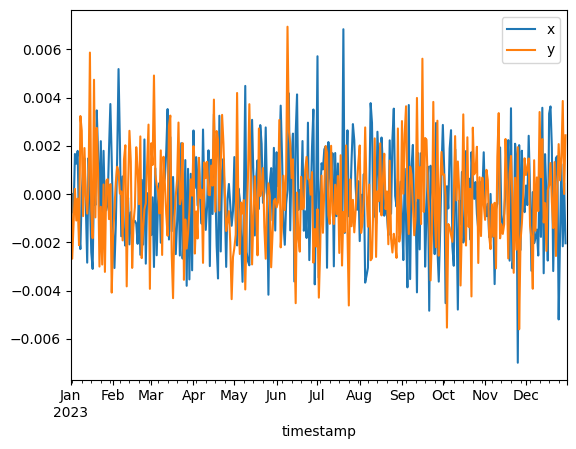

In [12]:
df[['x', 'y']].resample('24h').mean().compute().plot()

&emsp;아래의 마지막 예시는 데이터의 24시간 이동평균을 계산합니다.

In [13]:
df[["x", "y"]].rolling(window="24h").mean().head()

,x,y
timestamp,,
2023-01-01 00:00:00,0.680683,0.417529
2023-01-01 00:00:01,0.418575,-0.279493
2023-01-01 00:00:02,0.586982,-0.059863
2023-01-01 00:00:03,0.424447,-0.183723
2023-01-01 00:00:04,0.212572,-0.058015


&emsp;특정 날짜의 레코드를 추출하기 위해서 아래와 같이 작성할 수 있습니다.

In [14]:
df.loc["2023-01-01"]

,name,id,x,y
npartitions=1,,,,
2023-01-01 00:00:00.000000000,string,int32,float64,float64
2023-01-01 23:59:59.999999999,...,...,...,...


In [15]:
%time
df.loc["2023-01-01"].compute()

CPU times: total: 0 ns
Wall time: 0 ns


,name,id,x,y
timestamp,,,,
2023-01-01 00:00:00,Patricia,1037,0.680683,0.417529
2023-01-01 00:00:01,Victor,946,0.156466,-0.976515
2023-01-01 00:00:02,Zelda,976,0.923796,0.379397
2023-01-01 00:00:03,Zelda,971,-0.063157,-0.555303
2023-01-01 00:00:04,Jerry,970,-0.634929,0.444818
...,...,...,...,...
2023-01-01 23:59:55,Alice,1025,-0.555811,-0.781718
2023-01-01 23:59:56,George,979,0.962221,-0.192719
2023-01-01 23:59:57,Michael,1024,0.275005,-0.968179


---

# 인덱스 설정

&emsp;데이터는 인덱스 열을 기준으로 정렬됩니다. 인덱스를 활용하면 액세스, 조인, 그룹 작업을 빠르게 수행할 수 있습니다. 그러나 정렬 작업은 병렬로 수행하기에 적합하지 않기 때문에, 인덱스 설정은 중요하긴 하지만 자주 사용되지는 않습니다. 아래 예시에서는 `name` 열을 기준으로 데이터를 그룹화하고, 해당 열을 인덱스로 설정하겠습니다.  

In [16]:
df5 = df.set_index("name")
df5

,id,x,y
npartitions=26,,,
Alice,int32,float64,float64
Bob,...,...,...
...,...,...,...
Zelda,...,...,...
Zelda,...,...,...


In [17]:
df5 = df5.persist()
df5

,id,x,y
npartitions=26,,,
Alice,int32,float64,float64
Bob,...,...,...
...,...,...,...
Zelda,...,...,...
Zelda,...,...,...


In [18]:
%time
df5.loc['Alice'].compute()

CPU times: total: 0 ns
Wall time: 0 ns


,id,x,y
name,,,
Alice,1007,0.279517,0.032937
Alice,972,0.448821,-0.508052
Alice,1019,0.591078,-0.832464
Alice,973,-0.239383,-0.350229
Alice,1004,-0.655652,-0.919039
...,...,...,...
Alice,954,-0.139994,0.426810
Alice,1030,-0.673202,-0.666101
Alice,1071,-0.093775,-0.002630


---

# 그룹별 함수 적용하기

&emsp;이제 `df5`에 데이터가 이름(`name`)별로 정렬되었으므로, 이름을 통한 액세스 또는 사용자 정의 기능을 사용한 그룹별 적용과 같은 작업을 수행할 수 있습니다. 여기서는 각 이름에 대해 서로 다른 선형회귀 모델을 훈련해보도록 하겠습니다. 이 때 선형회귀 모델은 scikit-learn 패키지를 사용했습니다.  

In [19]:
from sklearn.linear_model import LinearRegression

def train(partition):
    if not len(partition):
        return
    est = LinearRegression()
    est.fit(partition[["x"]].values, partition.y.values)
    return est

&emsp;`train()`에 대한 인수 파티션(`partition`)은 `DataFrameGroupBy`의 그룹 인스턴스 중 하나입니다. 만약 해당 파티션에 데이터가 없다면 위 진행할 필요가 없습니다. 데이터가 있는 경우에는, 선형회귀 모델을 적합시키고 이 모델을 반환합니다.  

&emsp;아래 예시를 통해 인덱스가 이름(`name`)인 데이터프레임 `df5`를 사용하여, 이름 열을 기준으로 그룹화하고 위의 `train()` 함수를 각 그룹별로 실행하겠습니다. 먼저 `.groupby()`를 사용하여 이름으로 그룹화하고, `.apply()`를 사용하여 `DataFrameGroupBy`의 각 그룹에 대해 `train()`을 실행합니다.  

&emsp;`meta` 인수는 `.apply()`의 결과를 데이터프레임(`DataFrame`) 또는 시리즈(`Series`)로 어떻게 생성할지 방법을 설정합니다. 아래 예시의 경우, `train()`은 단일 값을 반환하므로 `.apply()`는 시리즈를 생성합니다. 따라서 단일 열의 유형이 무엇인지, 단일 열의 이름은 무엇으로 할지 지정해야 합니다. 이러한 것들을 지정하는 가장 쉬운 방법은 튜플`()`을 사용하는 것입니다. 튜플의 첫번째 요소로 열의 이름이 들어갑니다. 아래의 예에서는 열 이름을 "LinearRegression"으로 지정했습니다. 튜플의 두번째 요소는 데이터 유형입니다. 여기서는 선형회귀 모델 객체가 시리즈에 저장되므로 일반적인 객체를 가리키는 `object`로 지정합니다.

In [20]:
df6 = df5.groupby("name").apply(
    train, meta=("LinearRegression", object)
).compute()
df6

name
Alice       LinearRegression()
Bob         LinearRegression()
Charlie     LinearRegression()
Dan         LinearRegression()
Edith       LinearRegression()
Frank       LinearRegression()
George      LinearRegression()
Hannah      LinearRegression()
Ingrid      LinearRegression()
Jerry       LinearRegression()
Kevin       LinearRegression()
Laura       LinearRegression()
Michael     LinearRegression()
Norbert     LinearRegression()
Oliver      LinearRegression()
Patricia    LinearRegression()
Quinn       LinearRegression()
Ray         LinearRegression()
Sarah       LinearRegression()
Tim         LinearRegression()
Ursula      LinearRegression()
Victor      LinearRegression()
Wendy       LinearRegression()
Xavier      LinearRegression()
Yvonne      LinearRegression()
Zelda       LinearRegression()
Name: LinearRegression, dtype: string

---